# Setting Up Your Lab Environment

This guide shows you how to setup a Hashi environment for testing features in Consul, Vault, and Nomad. NOTE: Nomad portion not available, yet.

Things to note:
* If you use Enterprise binaries
  * Enterprise binaries (`+ent`) need to be licensed - set in `docker-compose*.yml`
  * Consul 1.9, Nomad 1.0, Vault 1.7 has a starter license of 6 hours.
  * Consul 1.10+, Nomad 1.1+, and Vault 1.8+ requires a license file or it won't start
  * `Prem` images have their licenses baked in.



## Prerequisites

### Set Key Variables for your environment

Customize `CONSUL_DC`, `CONSUL_DC_2`, and `CONSUL_DC_3` if desired.

In [ ]:
export CONSUL_DC=zone1 CONSUL_DC_2=zone2 CONSUL_DC_3=zone3
export COMPOSE_PROJECT_NAME=hashi
#// compose file - files on the right take precedence
#export COMPOSE_FILE=docker-compose.yml:docker-compose-proxy.yml:docker-compose-vault.yml:docker-compose-hashi.yml
export COMPOSE_FILE=docker-compose-proxy.yml:docker-compose-hashi.yml

In [ ]:
printf "$CONSUL_DC \n$CONSUL_DC_2 \n$CONSUL_DC_3 \n$COMPOSE_PROJECT_NAME \n$COMPOSE_FILE"

* `CONSUL_DC*` - is used for Consul config files, docker-compose files, and more.
* `COMPOSE_FILE` - specifies the docker-compose files to work with

### Install software

#### Prerequisite Software

For linux

In [ ]:
Install Ansible

In [ ]:
sudo apt install -qq unzip tree python3-pip

#### Hashi software

Customize the versions, architecture, and os for your environment. It's currently set for Ubuntu on Pi.

In [ ]:
VAULT_VER=1.8.5+ent #// +ent for enterprise
CONSUL_VER=1.10.4+ent
NOMAD_VER=1.2.2 #1.2.2+ent
ARCH=arm64 #// amd64, arm64
OS=linux #// darwin, linux

curl -o /tmp/vault.zip \
  https://releases.hashicorp.com/vault/${VAULT_VER}/vault_${VAULT_VER}_${OS}_${ARCH}.zip
curl -o /tmp/consul.zip \
  https://releases.hashicorp.com/consul/${CONSUL_VER}/consul_${CONSUL_VER}_${OS}_${ARCH}.zip
curl -o /tmp/nomad.zip \
  https://releases.hashicorp.com/nomad/${NOMAD_VER}/nomad_${NOMAD_VER}_${OS}_${ARCH}.zip

In [ ]:
for bin in consul vault nomad; do
sudo unzip -od /usr/local/bin /tmp/${bin}.zip && ${bin} version
done

In [ ]:
for bin in consul vault nomad; do
${bin} -autocomplete-install || true
done

Ubuntu Linux - UNDER DEVELOPMENT - NOT WORKING FOR ARM64

In [ ]:
ARCH=arm64
# curl -fsSL https://apt.releases.hashicorp.com/gpg | sudo apt-key add -
sudo apt-add-repository \
    "deb [arch=${ARCH}] https://apt.releases.hashicorp.com $(lsb_release -cs) main" \
    && sudo apt-get update #&& sudo apt-get install nomad

#### Docker and Docker Compose

* Ubuntu and Raspbian
  * https://dev.to/elalemanyo/how-to-install-docker-and-docker-compose-on-raspberry-pi-1mo

In [ ]:
#// docker
curl -sSL https://get.docker.com | sh
sudo usermod -aG docker ${USER}
sudo systemctl enable docker
#// docker-compose
sudo pip3 install docker-composesudo pip3 install docker-compose

* Mac - https://docs.docker.com/desktop/mac/install/

## Consul Setup - Primary

Create needed directories.

In [ ]:
mkdir -p consul/config
mkdir -p consul/cert/{server,client}

### Generate Consul Gossip Encryption Key

Generate encryption key for Gossip - UDP; same key for all agents; [more info](https://learn.hashicorp.com/tutorials/consul/gossip-encryption-secure)

In [ ]:
CONSUL_KEY=$(consul keygen)
echo $CONSUL_KEY

Sample Output: `qDOPBEr+/oUVeOFQOnVypxwDaHzLrD+lvjo5vCEBbZ0=`

### Create CA and Certs for RPC Encryption

#### Create Certificate Authority

Create Certificate Authority

In [ ]:
consul tls ca create || true

Output
```
==> Saved consul-agent-ca.pem
==> Saved consul-agent-ca-key.pem
```

Copy CA Public Key to shared `client` and `server` folders.

In [ ]:
for dir in client server; do
cp -v consul-agent-ca.pem consul/cert/${dir}/
done

#### Create Server and Client Certificates

Create server certificate and move it to shared `server` folder.

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do 
consul tls cert create -server -dc ${cluster}
mv ${cluster}-server-consul-*.pem consul/cert/server/
done

Output
```
==> WARNING: Server Certificates grants authority to become a
    server and access all state in the cluster including root keys
    and all ACL tokens. Do not distribute them to production hosts
    that are not server nodes. Store them as securely as CA keys.
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved west-server-consul-0.pem
==> Saved west-server-consul-0-key.pem
```

Output
```
==> WARNING: Server Certificates grants authority to become a
    server and access all state in the cluster including root keys
    and all ACL tokens. Do not distribute them to production hosts
    that are not server nodes. Store them as securely as CA keys.
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved east-server-consul-0.pem
==> Saved east-server-consul-0-key.pem
```

Create client certificate and move it to shared `client` folder - **DC 1**

In [ ]:
consul tls cert create -client -dc ${CONSUL_DC} && \
  mv ${CONSUL_DC}-client-consul-*.pem consul/cert/client

Output
```
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved west-client-consul-0.pem
==> Saved west-client-consul-0-key.pem
```

Create client certificate and move it to shared `client` folder - **DC 2**

In [ ]:
consul tls cert create -client -dc ${CONSUL_DC_2} && \
  mv ${CONSUL_DC_2}-client-consul-*.pem consul/cert/client

### Create Consul Configs

#### Consul Server Configuration

Create Core Consul config - Server

Using a generic configuration. Using CLI parameters to customize at run time.

In [ ]:
tee consul/config/server.hcl <<-EOF
datacenter  = "${CONSUL_DC}" # in CLI
# node_name   = "ConsulServer${i}" # in CLI or use hostname
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"
log_level   = "DEBUG"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/${CONSUL_DC}-server-consul-0.pem"
key_file    = "/consul/cert/${CONSUL_DC}-server-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

# server           =  true # in CLI
bootstrap_expect = 3
retry_join  = [ "consul-server-0", "consul-server-1", "consul-server-2" ]
ui_config { enabled = true } 

#// 5 is default multiplier
performance {
  raft_multiplier = 2 #// fast but not too fast
}

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

The config is generic-ish. The command in `docker-compose` file will specify more flags.

#### Consul Client Configuration

Create Core Consul config - Client

In [ ]:
tee consul/config/client.hcl <<-EOF
datacenter  = "${CONSUL_DC}" # in CLI
# node_name   = "ConsulServer${i}" # in CLI
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/${CONSUL_DC}-client-consul-0.pem"
key_file    = "/consul/cert/${CONSUL_DC}-client-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

ui               = true
retry_join  = [ "consul-server-0", "consul-server-1", "consul-server-2" ]

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

### Start Consul docker-compose up

We will now bring up the three Consul servers and one client for our first Datacenter. I use `--force-recreate` to have Docker recreate the containers. This is handy for a fresh start when testing code bits.

In [ ]:
#// Check your docker-compose configuration
docker-compose config

Make sure DC variable is set. If not see the Prerequisites.

In [ ]:
echo ${CONSUL_DC}

In [ ]:
docker-compose \
  up --force-recreate -d \
  consul-server-0 consul-server-1 consul-server-2 consul-agent-1

> NOTE: We specify only the containers we want to bring up. If you don't specify something, then everything comes up.

Verify containers are up

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=consul

### Verify Consul

In [ ]:
for i in {0..2}; do
docker logs consul-server-${i} | (head; tail -n 5)
done

Quick check to make sure your Consul environment is running correctly.

In [ ]:
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services

You should see something like the following.

* There should be three servers. `DC` should match

```#==> List Members
Node             Address        Status  Type    Build       Protocol  DC    Segment
consul-server-0  10.5.0.2:8301  alive   server  1.9.11+ent  2         west  <all>
consul-server-1  10.5.0.3:8301  alive   server  1.9.11+ent  2         west  <all>
consul-server-2  10.5.0.4:8301  alive   server  1.9.11+ent  2         west  <all>
```

* There should be a leader and two followers.

```
#==> List Raft Peers
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-2  08f89457-d9db-b025-c65e-185246fe577c  10.5.0.4:8300  leader    true   3
consul-server-1  f4c7057f-83ec-11ac-2027-ca85eccfce89  10.5.0.3:8300  follower  true   3
consul-server-0  2c965ad0-5042-424c-259c-a5781d001d28  10.5.0.2:8300  follower  true   3
```

```
#==> List services from Consul catalog
consul
```

## Vault Setup - Primary

### Create Vault Configs

In [ ]:
# Create Vault Directories
for node in {1..5}; do
mkdir -p vault/config/vault_s${node}
mkdir -p vault/logs/vault_s${node}
done

In [ ]:
# Create Vault Server Config
for i in {1..3}; do
cat > vault/config/vault_s${i}/server${i}.hcl <<-EOF
# Note: this file will be re-written by script
api_addr     = "http://10.5.0.10${i}:8200"
cluster_addr = "https://10.5.0.10${i}:8201"
cluster_name = "cluster-a"
disable_mlock = true

# Base Configuration
listener "tcp" {
  address = "0.0.0.0:8200"
  tls_disable = "true"
#   #tls_cert_file = "/etc/ssl/certs/vault-server.crt"
#   #tls_key_file  = "/etc/ssl/vault-server.key"
}

ui = "true"
log_level="INFO"

# Raft configuration
storage "raft" {
  path    = "/vault/file"
  node_id = "vault_s${i}"
  retry_join {
    leader_api_addr = "http://vault_s1:8200"
  }
  retry_join {
    leader_api_addr = "http://vault_s2:8200"
  }
  retry_join {
    leader_api_addr = "http://vault_s3:8200"
  }
}

service_registration "consul" {
  address = "consul-server-0:8500"
}

telemetry {
  prometheus_retention_time = "30s"
  disable_hostname          = true
}
# raw_storage_endpoint = true #//for debugging
EOF
done

### Vault docker-compose up

In [ ]:
# Restart Vault Cluster
docker-compose up --force-recreate -d \
  vault_s1 vault_s2 vault_s3

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=vault

### Init Vault `init.sh`

In [ ]:
export VAULT_ADDR=http://localhost:8200

In [ ]:
printf "#==> Init vault_s1 \n"
#// Confirm that vault_s1 is listening on port 8200
while ! nc -w 1 127.0.0.1 8200 </dev/null; do sleep 1; done
time vault operator init -format=json -n 1 -t 1 > /tmp/vault.init

In [ ]:
export VAULT_TOKEN_PRIMARY=$(jq -r '.root_token' /tmp/vault.init)
printf "\nRoot VAULT TOKEN is: $VAULT_TOKEN_PRIMARY \n"
printf "\n*** Please Run: export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY} \n"
export unseal_key=$(jq -r '.unseal_keys_b64[0]' /tmp/vault.init)
printf "\nUnseal Key is: ${unseal_key}\n"
export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY}

### Unseal Vault `unseal.sh`

In [ ]:
vault operator unseal ${unseal_key}

In [ ]:
while ! vault operator raft list-peers > /dev/null 2>&1 ; do 
  sleep 1; echo "waiting..."
done
vault operator raft autopilot state

for i in {2..3}; do
docker exec -i vault_s${i} sh <<EOM
printf "\n#==> Unsealing:\n"
hostname
export VAULT_ADDR=http://localhost:8200
vault operator unseal ${unseal_key}
EOM
done

### Verify Vault

In [ ]:
printf "#==> Check token\n"
vault token lookup
printf "\n#==> Check status\n"
vault status

In [ ]:
printf "#==> List Peers\n"
vault operator raft list-peers
printf "\n#==> Show autopilot state\n"
vault operator raft autopilot state || true
printf "\n#==> Show autopilot settings\n"
vault operator raft autopilot get-config || true

In [ ]:
vault secrets list
vault read sys/license

In [ ]:
# vault write sys/license text=@vault/config/vault.hclic && \
# vault read sys/license

In [ ]:
vault secrets enable kv
# vault write kv/game/account username=foo password=bar

Create `superuser` policy

In [ ]:
vault policy write superuser -<<EOF
path "*" {
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}
EOF


Create `admin` Policy

In [ ]:
vault policy write admin - <<EOF
# Read system health check
path "sys/health"
{
  capabilities = ["read", "sudo"]
}

# Create and manage ACL policies broadly across Vault

# List existing policies
path "sys/policies/acl"
{
  capabilities = ["list"]
}

# Create and manage ACL policies
path "sys/policies/acl/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Enable and manage authentication methods broadly across Vault

# Manage auth methods broadly across Vault
path "auth/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Create, update, and delete auth methods
path "sys/auth/*"
{
  capabilities = ["create", "update", "delete", "sudo"]
}

# List auth methods
path "sys/auth"
{
  capabilities = ["read"]
}

# Enable and manage the key/value secrets engine at `secret/` path

# List, create, update, and delete key/value secrets
path "secret/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets engines
path "sys/mounts/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List existing secrets engines.
path "sys/mounts"
{
  capabilities = ["read"]
}
EOF

In [ ]:
for i in {1..10}; do
vault secrets enable -path=kv-app-${i} kv
done

In [ ]:
for i in {1..10}; do
vault write kv/game/account-${i} username=foo-${i} password=bar
vault read kv/game/account-${i} > /dev/null
vault kv put kv-peter/data/game/account-${i} username=foo-${i} password=bar
vault kv get kv-peter/data/game/account-${i} > /dev/null
done

In [ ]:
for i in {1..10}; do
vault kv put kv-app-${i}/game/account-${i} username=foo-${i} password=bar
vault kv get kv-app-${i}/game/account-${i} > /dev/null
done

In [ ]:
for i in {1..10}; do
vault token create \
  -field=token \
  -policy prometheus-metrics
done

In [ ]:
vault secrets list -detailed

## Monitoring

In this scenario, you will use Docker containers to deploy a Vault server, Prometheus monitoring, and a Grafana dashboard.

You will configure Vault to enable Prometheus metrics, and deploy the containers using the command line in a terminal session. You will also use the Grafana web interface to create a dashboard for visualizing metrics.

Begin the scenario by preparing your environment.

### Prerequisites

* [Vault Cluster](#Vault-Setup---Primary)

In [ ]:
mkdir -p grafana/provisioning/{datasources,dashboards} \
  grafana/dashboards prometheus

### Vault configuration

Prometheus metrics are not enabled by default. Setting the `prometheus_retention_time` to a non-zero value enables them.

```
telemetry {
  prometheus_retention_time = "1h"
  disable_hostname          = true
}
```

* `prometheus_retention_time = "1h"` retain in memory for 1 hour
* `disable_hostname = true` - do not emit Prometheus metrics prefixed with host names, which is not desirable in most cases
* Go to [telemetry parameters](https://www.vaultproject.io/docs/configuration/telemetry#telemetry-parameters) documentation for more details.


This configuration was already included in the prerequisite sections.

### Prometheus Configuration

#### Vault Integration

Prep vault token for Prometheus.

In [ ]:
printf "$(jq -r '.root_token' /tmp/vault.init)" > prometheus/prometheus-token
cat prometheus/prometheus-token

Define a prometheus-metrics ACL policy that grants read capabilities to the metrics endpoint.

In [ ]:
vault policy write prometheus-metrics - << EOF
path "/sys/metrics" {
  capabilities = ["read"]
}
EOF

In [ ]:
cat > prometheus/prometheus.yml << EOF
# Generated via hashistack playbook
global:
  scrape_interval: 5s #default 1m
  scrape_timeout: 3s #default 10s

scrape_configs:
  - job_name: services
    metrics_path: /metrics
    static_configs:
      - targets:
        - 'prometheus:9090'
  - job_name: node
    metrics_path: /metrics
    static_configs:
      - targets:
        - 'node-exporter:9100'

  - job_name: 'consul-server'
    metrics_path: '/v1/agent/metrics'
    params:
      format: ['prometheus']
    static_configs:
      - targets: 
        - 'consul-server-0:8500'
        - 'consul-server-1:8500'
        - 'consul-server-2:8500'
        - 'consul-server-3:8500'
        - 'consul-server-4:8500'
        - 'consul-server-5:8500'
        - 'consul-agent-1:8500'

  - job_name: 'tempo'
    static_configs:
      - targets: ['tempo:3100']

  - job_name: vault
    metrics_path: /v1/sys/metrics
    params:
      format: ['prometheus']
    scheme: http
    authorization:
      credentials_file: /etc/prometheus/prometheus-token
    # static_configs:
    #   - targets: ['vault_s1:8200','vault_s2:8200','vault_s3:8200']
    #// dynamic targets via Consul
    consul_sd_configs:
      - server: 'consul-server-0:8500'
        services: ['vault']

  - job_name: vault_4
    metrics_path: /v1/sys/metrics
    params:
      format: ['prometheus']
    scheme: http
    authorization:
      credentials_file: /etc/prometheus/prometheus-token-2
    consul_sd_configs:
      - server: 'consul-server-0:8500'
        services: ['vault-4']

  #// Container monitoring
  - job_name: cadvisor
    scrape_interval: 5s
    metrics_path: '/metrics'
    static_configs:
    - targets:
      - cadvisor:8080

EOF

Prometheus Jobs
* `prometheus`
* `consul`
* `vault`
* `nomad` - need to add
* `cadvisor`

### Start Prometheus docker-compose up

In [ ]:
# Restart Prometheus
docker-compose up --force-recreate -d prometheus

In [ ]:
docker logs -n 1 prometheus

The log should contain an entry like this one.
```shell
level=info ts=2021-11-20T01:29:46.330Z caller=main.go:767 msg="Server is ready to receive web requests."
```

#### Validate Prometheus

* Go to UI - http://<prometheus_ip>:9090
    * ex http://192.168.17.101:9090
* Run of some the following queries

| Metric | Description | |
| --- | --- | --- |
| `consul_raft_apply` | | |
| cAdvisor | | |
| `container_start_time_seconds` | The start time of containers (in seconds). You can select for specific containers by name using the `name="<container_name>"` expression.
| `rate(container_cpu_usage_seconds_total{name="consul-server-0"}[1m])` | The cgroup's CPU usage in the last minute
| `container_memory_usage_bytes{name="redis"}` | The cgroup's total memory usage (in bytes)
| `rate(container_network_transmit_bytes_total[1m])` | [link](http://192.168.17.101:9090/graph?g0.range_input=1h&g0.expr=rate(container_network_transmit_bytes_total%5B1m%5D)&g0.tab=1) - Bytes transmitted over the network by the container per second in the last minute
| `rate(container_network_receive_bytes_total[1m])` | Bytes received over the network by the container per second in the last minute

##### Reload prometheus if config has been modified.

In [ ]:
docker exec prometheus kill -HUP 1
# curl -X POST http://localhost:9090/-/reload

#### node-exporter

In [ ]:
# Restart node-exporter
docker-compose up --force-recreate -d node-exporter

Verify the status of node-exporter by checking its logs.

In [ ]:
docker logs -n5 node-exporter

Output
```shell
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=vmstat
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=xfs
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=zfs
ts=2021-12-08T05:58:35.399Z caller=node_exporter.go:199 level=info msg="Listening on" address=:9100
ts=2021-12-08T05:58:35.399Z caller=tls_config.go:195 level=info msg="TLS is disabled." http2=false
```

In [ ]:
# Restart cAdvisor
docker-compose up --force-recreate -d cadvisor

### Grafana Configuration

In [ ]:
cat > grafana/datasource.yml << EOF
# config file version
apiVersion: 1

datasources:
- name: vault
  type: prometheus
  access: server
  orgId: 1
  url: http://10.42.74.110:9090
  password:
  user:
  database:
  basicAuth:
  basicAuthUser:
  basicAuthPassword:
  withCredentials:
  isDefault:
  jsonData:
     graphiteVersion: "1.1"
     tlsAuth: false
     tlsAuthWithCACert: false
  secureJsonData:
    tlsCACert: ""
    tlsClientCert: ""
    tlsClientKey: ""
  version: 1
  editable: true
EOF

In [ ]:
cat > grafana/provisioning/datasources/datasource_peter.yml << EOF
# config file version
apiVersion: 1
# list of datasources to insert/update depending
# what's available in the database
datasources:
- name: Loki
  type: loki
  access: proxy
  orgId: 1
  url: http://loki:3100
  basicAuth: false
  isDefault: true
  version: 1
  editable: false
  apiVersion: 1
  jsonData:
    derivedFields:
      - datasourceUid: tempo
        matcherRegex: (?:traceID|trace_id)=(\w+)
        name: TraceID
        url: $${__value.raw}


EOF

In [ ]:
cat > grafana/provisioning/datasources/datasource_prometheus.yml << EOF
# config file version
apiVersion: 1
# list of datasources to insert/update depending
# what's available in the database
datasources:
- name: Prometheus
  type: prometheus
  access: proxy
  orgId: 1
  url: http://prometheus:9090
  # basicAuth: false
  isDefault: false
  version: 1
  editable: true
  apiVersion: 1

EOF

In [ ]:
chmod 755 grafana/provisioning/datasources/datasource.yml
chmod -R 755 grafana/provisioning
chmod -R 755 grafana/dashboards

In [ ]:
ll grafana/dashboards consul/config/

* `grafana/dashboards:/var/lib/grafana/dashboards` - preconfigured dashboards

### Start Grafana docker-compose up

In [ ]:
# Restart Grafana
docker-compose up --force-recreate -d grafana

Validate Grafana

1. Go to `http://<grafana_ip>:3000` ex http://192.168.17.101:3000

#### Generate Traffic

Install dns tools into Consul server

In [ ]:
docker exec consul-server-0 apk add bind-tools

Run Consul load script. **TODO** Need to add more.

In [ ]:
docker exec -i consul-server-0 sh <<"EOM"
cat > test_dns.sh <<"EOF"
#!/bin/sh
i=0
while [ $i -lt 100 ];do
dig @consul-server-0 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-0 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
export CONSUL_HTTP_ADDR=http://consul-server-0:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-1:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-2:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
echo ${i}.c >> /tmp/test_dns.out
sleep 1
i=$(( $i +1 ))
done
EOF
chmod +x test_dns.sh
nohup ./test_dns.sh &
EOM

Look at these charts.
* Transaction Times
* System Stats
* DNS


#### Customizations

Raft Election
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background

Raft Election
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background
Raft Commit Time
* consul_raft_commitTime
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background
* Thresholds - Base, 80, 160

Grafana Dashboards
* cadvisor - https://grafana.com/grafana/dashboards/193

## Vault Monitoring

Install dns tools into Consul server

In [ ]:
docker exec vault_s1 \
    apk add bind-tools dig

Run Consul load script. **TODO** Need to add more.

In [ ]:
docker exec -i consul-server-0 sh <<"EOM"
cat > test_dns.sh <<"EOF"
#!/bin/sh
i=0
while [ $i -lt 100 ];do
dig @consul-server-0 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-0 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
export CONSUL_HTTP_ADDR=http://consul-server-0:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-1:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-2:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
echo ${i}.c >> /tmp/test_dns.out
sleep 1
i=$(( $i +1 ))
done
EOF
chmod +x test_dns.sh
nohup ./test_dns.sh &
EOM

Look at these charts.
* Transaction Times
* System Stats
* DNS


## Vault Performance Nodes

optional - Vault Performance Nodes
* main difference here is that it does not auto-join
* joining manually as non-voter from CLI
* https://learn.hashicorp.com/tutorials/vault/performance-standbys?in=vault/enterprise

In [ ]:
# Create Vault Server Config
for i in {4..5}; do
cat > vault/config/vault_s${i}/server${i}.hcl <<-EOF
# Note: this file will be re-written by script
api_addr     = "http://10.5.0.10${i}:8200"
cluster_addr = "https://10.5.0.10${i}:8201"
disable_mlock = true

# Base Configuration
listener "tcp" {
  address = "0.0.0.0:8200"
  tls_disable = "true"
}

ui = "true"
log_level="INFO"

# Raft configuration
storage "raft" {
  path    = "/vault/file"
  node_id = "vault_s${i}"
}

service_registration "consul" {
  address = "consul-server-0:8500"
}
EOF
done

### Vault Performance Nodes docker-compose up

In [ ]:
# Restart Vault Cluster
docker-compose -f docker-compose-hashi.yml up --force-recreate -d \
  vault_s4

In [ ]:
docker exec -i vault_s4 sh -s <<EOM
export VAULT_ADDR=http://127.0.0.1:8200
vault operator raft join -non-voter http://vault_s1:8200
EOM

In [ ]:
export unseal_key=$(cat /tmp/vault.init | jq -r '.unseal_keys_b64[0]')
printf "${unseal_key}\n"

for i in {4..4}; do
docker exec -i vault_s${i} sh <<EOM
export VAULT_ADDR=http://localhost:8200
vault operator unseal ${unseal_key}
EOM
done

In [ ]:
vault operator raft list-peers

* `vault_s4` is not a voter.

## Vault Replication

In this section we are going to:
* Add a Performance Replication cluster (Cluster C, single node, `vault_s5`) - more [info](https://learn.hashicorp.com/tutorials/vault/performance-replication?in=vault/enterprise)
* Add a DR Cluster (Cluster B, single node, `vault_s4`) - more [info](https://learn.hashicorp.com/tutorials/vault/disaster-recovery)

<img alt=image.png src=attachment:6e11e8ab-ab48-4766-8458-356ec45de010.png width=640>
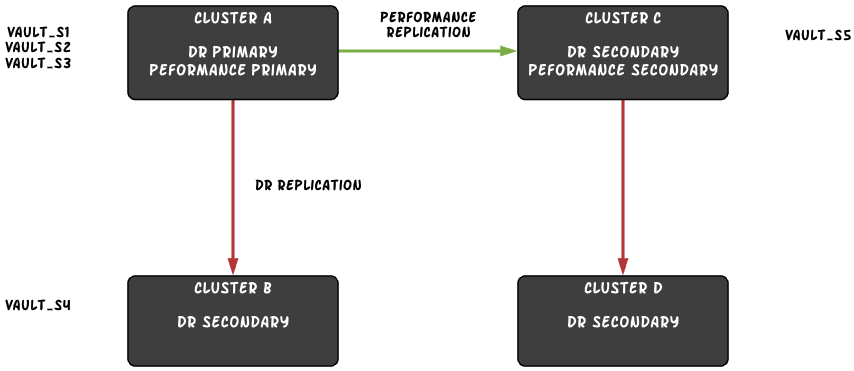

If you want the secondary Vault Cluster to register with a secondary Consul Cluster, the do this [step](#Consul-Federation-Using-WAN-Gossip) as well.

### Create Vault Configuration - Secondary

Change service registration from `consul-server-0` to `consul-server-4` if desired.

In [ ]:
# Create Vault Server Config WITH ANSIBLE
cat > /tmp/vault.hcl.j2 <<-EOF
# Note: this file will be re-written by script
api_addr     = "http://10.5.0.10{{node_number}}:8200"
cluster_addr = "https://10.5.0.10{{node_number}}:8201"
cluster_name = "{{cluster_name}}"
disable_mlock = true

# Base Configuration
listener "tcp" {
  address = "0.0.0.0:8200"
  tls_disable = "true"
}

ui = "true"
log_level="INFO"

# Raft configuration
storage "raft" {
  path    = "/vault/file"
  node_id = "vault_s{{node_number}}"
}

service_registration "consul" {
  address = "consul-server-0:8500"
  service = "vault-{{node_number}}"
}

telemetry {
  prometheus_retention_time = "30s"
  disable_hostname          = true
}
# raw_storage_endpoint = true #//for debugging
EOF

In [ ]:
ansible localhost -m template -a "src=/tmp/vault.hcl.j2 dest=/tmp/vault_s4.hcl" \
    --extra-vars "node_number=4 cluster_name=cluster-b"
ansible localhost -m template -a "src=/tmp/vault.hcl.j2 dest=/tmp/vault_s5.hcl" \
    --extra-vars "node_number=5 cluster_name=cluster-c"

In [ ]:
cat /tmp/vault_s4.hcl
cat /tmp/vault_s5.hcl

In [ ]:
# Create Vault Server Config
for i in {4..6}; do
tee vault/config/vault_s${i}/server${i}.hcl <<-EOF
# Note: this file will be re-written by script
api_addr     = "http://10.5.0.10${i}:8200"
cluster_addr = "https://10.5.0.10${i}:8201"
cluster_name = "cluster-b"
disable_mlock = true

# Base Configuration
listener "tcp" {
  address = "0.0.0.0:8200"
  tls_disable = "true"
}

ui = "true"
log_level="INFO"

# Raft configuration
storage "raft" {
  path    = "/vault/file"
  node_id = "vault_s${i}"
  # retry_join {
  #   leader_api_addr = "http://vault_s4:8200"
  # }
  # retry_join {
  #   leader_api_addr = "http://vault_s5:8200"
  # }
  # retry_join {
  #   leader_api_addr = "http://vault_s6:8200"
  # }
}

service_registration "consul" {
  address = "consul-server-0:8500"
  service = "vault-${i}"
}

telemetry {
  prometheus_retention_time = "30s"
  disable_hostname          = true
}
# raw_storage_endpoint = true #//for debugging
EOF
done

### Vault DR Nodes docker-compose up

In [ ]:
# Restart Vault Cluster
docker-compose up --force-recreate -d \
  vault_s5

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=vault

In [ ]:
# Restart Vault Cluster
docker-compose up --force-recreate -d \
  vault_s5

### Init Vault `init.sh` - PR Secondary

Initialize `vault_s5`. Save info to `/tmp/vault_secondary.init`.

In [ ]:
printf "#==> Init vault_s5 \n"
docker exec \
  -e VAULT_ADDR=http://localhost:8200 \
  vault_s5 vault operator init -format=json -n 1 -t 1 > /tmp/vault_secondary.init

In [ ]:
export root_token2=$(jq -r '.root_token' /tmp/vault_secondary.init)
printf "Root VAULT TOKEN 2 is: $root_token2 \n"

export unseal_key2=$(cat /tmp/vault_secondary.init | jq -r '.unseal_keys_b64[0]')
printf "Unseal Key 2 is:       ${unseal_key2}\n"

### Unseal Vault `unseal.sh` - PR Secondary

In [ ]:
docker exec -i \
    -e VAULT_ADDR=http://localhost:8200 \
    vault_s5 vault operator unseal ${unseal_key2}

**TIP**: After setting up replication, you will use the unseal keys from the primary cluster.

Check raft info on `vault_s5`.

In [ ]:
docker exec -i \
    -e VAULT_ADDR=http://localhost:8200 \
    -e VAULT_TOKEN=$root_token2 \
vault_s5 sh <<EOM
printf "#==> Raft peers \n"
vault operator raft list-peers
printf "\n#==> Autopilot state \n"
vault operator raft autopilot state
EOM

# for i in {5..6}; do
# docker exec -i vault_s${i} sh <<EOM
# printf "\n#==> Unsealing:\n"
# hostname
# export VAULT_ADDR=http://localhost:8200
# vault operator unseal ${unseal_key2}
# EOM
# done

### Verify Vault

Verify status and token for `Cluster B` from `vault_s5`.

In [ ]:
docker exec -i vault_s5 sh <<EOM
export VAULT_TOKEN=$root_token2
vault token lookup
printf "\n#==> Vault Status \n"
vault status
EOM

### Enable Replication on Primary - PR and DR

Enable `DR` and `Performance` Replication as `Primary` on `Cluster A` on `vault_s1`.

In [ ]:
export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY}
printf "#==> Enable Performance Replication as primary\n"
vault write -f sys/replication/performance/primary/enable
printf "#==> Enable Disaster Replication as secondary\n"
vault write -f sys/replication/dr/primary/enable || true

(optional) Revoke **Performance** Secondary Token

In [ ]:
vault write sys/replication/performance/primary/revoke-secondary id=perfsec || true

In [ ]:
printf "#==> Generate a PR secondary token.\n"
vault write -field wrapping_token sys/replication/performance/primary/secondary-token id=perfsec \
  > /tmp/secondaryToken.out && cat /tmp/secondaryToken.out

In [ ]:
secondaryToken=$(cat /tmp/secondaryToken.out)

Revoke **DR** Secondary Token

In [ ]:
vault write sys/replication/dr/primary/revoke-secondary id=drsec || true

Generate **DR** Secondary Token

In [ ]:
printf "#==> Generate a DR secondary token.\n"
vault write -field wrapping_token sys/replication/dr/primary/secondary-token id=drsec \
  > /tmp/drSecondaryToken.out && cat /tmp/drSecondaryToken.out

drSecondaryToken=$(cat /tmp/drSecondaryToken.out)

### Enable Replication on Secondary - PR

Enable `Performance` Replication as `Secondary` on `Cluster C` on `vault_s5`.

In [ ]:
echo $root_token2
echo $secondaryToken

In [ ]:
docker exec -i vault_s5 sh <<EOM
printf "#==> Enable Performance Replication as secondary\n"
export VAULT_TOKEN=$root_token2
vault write sys/replication/performance/secondary/enable token=$secondaryToken
EOM

#### Verify Replication Status

Verify Replication on all three clusters. `vault_s4` should fail DR Secondary status since it has not been setup, yet.

In [ ]:
printf "\n#==> Status of Performance Primary\n"
vault read sys/replication/performance/status || true
printf "\n#==> Status of Performance Secondary\n"
docker exec vault_s5 sh -c "vault read sys/replication/performance/status" || true
printf "\n#==> Status of DR Primary\n"
vault read sys/replication/dr/status || true
printf "\n#==> Status of DR Secondary\n"
docker exec vault_s4 sh -c "vault read sys/replication/dr/status" || true

### DR Secondary

In [ ]:
# Restart Vault Cluster
docker-compose up --force-recreate -d \
  vault_s4

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=vault

#### Init Vault `init.sh` - DR Secondary

In [ ]:
printf "#==> Init vault_s4 \n"
docker exec \
  -e VAULT_ADDR=http://localhost:8200 \
  vault_s4 vault operator init -format=json -n 1 -t 1 > /tmp/vault_drsecondary.init

In [ ]:
export root_token3=$(jq -r '.root_token' /tmp/vault_drsecondary.init)
printf "Root VAULT TOKEN 3 is: $root_token3 \n"

export unseal_key3=$(cat /tmp/vault_drsecondary.init | jq -r '.unseal_keys_b64[0]')
printf "Unseal Key 3 is:       ${unseal_key3}\n"

#### Unseal Vault `unseal.sh` - DR Secondary

In [ ]:
docker exec -i \
    -e VAULT_ADDR=http://localhost:8200 \
    vault_s4 vault operator unseal ${unseal_key3}

#### Verify Vault - DR Secondary

In [ ]:
docker exec -i \
    -e VAULT_ADDR=http://localhost:8200 \
    -e VAULT_TOKEN=$root_token3 \
    vault_s4 sh <<EOM
vault token lookup
vault status
vault version
vault operator raft list-peers
EOM

### Enable Replication on Secondary - DR

In [ ]:
docker exec -i \
    -e VAULT_TOKEN=$root_token3 \
    vault_s4 sh <<EOM
printf "#==> Enable DR as secondary\n"
vault write sys/replication/dr/secondary/enable token=$drSecondaryToken
EOM

In [ ]:
printf "\n#==> Status of PR Primary\n"
vault read sys/replication/performance/status || true
printf "\n#==> Status of PR Secondary\n"
docker exec vault_s5 sh -c "vault read sys/replication/performance/status || true"
printf "\n#==> Status of DR Primary\n"
vault read sys/replication/dr/status || true
printf "\n#==> Status of DR Secondary\n"
docker exec vault_s4 sh -c "vault read sys/replication/dr/status || true"

### Promote Secondary - DR

#### Batch Token for Replication Operations

Create a policy named "`dr-secondary-promotion`".

https://learn.hashicorp.com/tutorials/vault/disaster-recovery#dr-operation-token-strategy

In [ ]:
vault policy write dr-secondary-promotion - <<EOF
path "sys/replication/dr/secondary/promote" {
  capabilities = [ "update" ]
}

# To update the primary to connect
path "sys/replication/dr/secondary/update-primary" {
    capabilities = [ "update" ]
}

# Only if using integrated storage (raft) as the storage backend
# To read the current autopilot status
path "sys/storage/raft/autopilot/state" {
    capabilities = [ "update" , "read" ]
}
EOF

Create a token role named "`failover-handler`" with the `dr-secondary-promotion` policy attached and its type should be `batch`.

In [ ]:
vault write auth/token/roles/failover-handler \
    allowed_policies=dr-secondary-promotion \
    orphan=true \
    renewable=false \
    token_type=batch

Create a token for role, "`failover-handler`" with time-to-live (TTL) set to 8 hours.

In [ ]:
vault token create -format=json -role=failover-handler -ttl=8h | tee /tmp/bToken.out | jq .auth
bToken=$(jq -r .auth.client_token /tmp/bToken.out)

Promote the DR secondary (Cluster B) to become the new primary. The request must pass the DR operation token.

In [ ]:
docker exec vault_s5 \
  sh -c "vault write sys/replication/dr/secondary/promote dr_operation_token=$bToken"

Sample Output:
```
WARNING! The following warnings were returned from Vault:

  * This cluster is being promoted to a replication primary. Vault will be
  unavailable for a brief period and will resume service shortly.
```

### Configure Prometheus for Vault Replication Clusters

In [ ]:
echo $root_token2 $VAULT_TOKEN_PRIMARY

In [ ]:
docker exec -i \
    vault_s1 sh <<"EOF"
    vault login -method=userpass username=mitchellh password=foo
    echo Vault Token $VAULT_TOKEN 
    vault token lookup
    vault status
    vault policy read admins
    vault secrets list
EOF
    # -e VAULT_TOKEN=$VAULT_TOKEN_PRIMARY \


##### Create token for prometheus

In [ ]:
docker exec -i \
    vault_s4 sh <<"EOF"
#apk add curl
vault login -method=userpass username=mitchellh password=foo ttl=1h
vault token create -field=token -policy=superuser > /tmp/root_token2
vault token lookup $(cat /tmp/root_token2)
#curl -H "X-Vault-Token: ${PROM_TOKEN}" http://127.0.0.1:8200/v1/sys/metrics?format=prometheus
EOF

In [ ]:
docker exec vault_s4 cat /tmp/root_token2 > prometheus/prometheus-token-2
docker exec -i prometheus sh <<EOF
echo $(cat prometheus/prometheus-token-2) > /etc/prometheus/prometheus-token-2
EOF

##### Reload prometheus if config has been modified.

In [ ]:
docker exec prometheus kill -HUP 1
# curl -X POST http://localhost:9090/-/reload

## haproxy - Load Balancer

In this section, we will set up haproxy to provide performance and high-availability for Vault. Client requests sent to haproxy for Vault will treated the following way:

* `GET` requests will be round-robined to all Vault nodes
* Non-`GET` requests will be sent only to the active Vault node.

### Prerequisites

* [Vault Cluster](#Vault-Setup---Primary)

### Bring up the load balancer

In [ ]:
docker-compose -f docker-compose-hashi.yml \
  -f docker-compose-proxy.yml up --force-recreate -d \
  haproxy

### Validate

In [ ]:
export VAULT_TOKEN=$(cat /tmp/vault.init | jq -r '.root_token')

#### Write test

Send POST (Write) request - Should go to "active" backend

In [ ]:
curl -H "X-Vault-Token: ${VAULT_TOKEN}" \
  -X POST \
  -d '{"data":{"foo":"bar"}}' \
  http://127.0.0.1:18200/v1/kv/data/game/account | jq -c
docker logs haproxy 2>&1 | tail -n 1

This should go to active server from `primary_cluster_active_api` backend.
```
... primary_cluster_api primary_cluster_active_api/vault-active 0/1/252 389 -- 1/1/0/0/0 0/0
```

#### Read test

Send several GET (Read) requests - Should go to different nodes in "read" backend.

In [ ]:
for i in {1..9}; do
curl -s -H "X-Vault-Token: ${VAULT_TOKEN}" \
  -X GET \
  http://127.0.0.1:18200/v1/kv/data/game/account | jq -c .data.data
docker logs haproxy 2>&1 | tail -n 1
done

This should go to any server from `vault_read` backend
```
... primary_cluster_api vault_read/vault_s2 0/0/6 423 -- 1/1/0/0/0 0/0
```

More info:

* https://learn.hashicorp.com/tutorials/consul/load-balancing-haproxy

### Reload haproxy

If you make changes to `haproxy.cfg`, you can reload `haproxy`.

In [ ]:
docker kill -s HUP haproxy

# Clean Up

If you are done with your tests, you might want to shut everything down to reduce your heating bills.

## Stop containers docker-compose down - everything

Make sure your prerequisite [environment variables](#Set-Key-Variables-for-your-environment) are set.

In [ ]:
printf "
Consul Datacenters   - $CONSUL_DC $CONSUL_DC_2 $CONSUL_DC_3
Compose Project Name - $COMPOSE_PROJECT_NAME
Compose Files        - $COMPOSE_FILE
"

In [ ]:
docker-compose down

Restart Services

In [ ]:
docker-compose restart

## DEBUGGING

### Review logs

Review consul logs - for docker

In [ ]:
for i in {0..3}; do
printf "docker logs consul-server-${i}\n"
docker logs consul-server-${i} | { head ; tail -n 3;}
printf "\n"
done

# Appendix

## Addresses


| Name | Address | Description |
| :--- | --- | --- |
| Consul | http://192.168.17.101:8500 | Consul Dashboard
| Nomad | http://192.168.17.101:4646 | Nomad Dashboard
| Vault | http://192.168.17.101:8200 | Vault Dashboard
| Prometheus | http://192.168.17.101:9090<br>http://192.168.17.101:9090/targets | Prometheus Dashboard
| Grafana | http://192.168.17.101:3000 | Grafana Dashboard
| cadvisor | http://192.168.17.101:8080<br>http://192.168.17.101:8080/docker/consul-server-0<br>http://192.168.17.101:8080/docker/vault_s1| cAdvisor Dashboard
| haproxy stats | http://192.168.17.101:11936 | haproxy Consul Dashboard
| haproxy - Consul | http://192.168.17.101:18500 | haproxy Consul Dashboard
| haproxy - Nomad | http://192.168.17.101:14646 | haproxy Nomad Dashboard
| haproxy - Vault | http://192.168.17.101:18200 | haproxy Vault Dashboard
| | |
| demo-webapp | http://192.168.17.101:8080 | web - shows db creds
| Consul 2 | http://192.168.17.101:8520 | Consul Dashboard
| Vault PR Secondary | http://192.168.17.101:8210 | Vault Dashboard
| Vault DR Secondary | http://192.168.17.101:8220 | Vault Dashboard


## Passwords

In [ ]:
printf "\n*** Please Run: export VAULT_TOKEN=${VAULT_TOKEN} \n"

## Directory Structure

In [ ]:
tree

Sample Output for tree
<details><summary></summary>

```
.
├── README.md
├── consul
│   ├── cert
│   │   ├── client
│   │   │   ├── consul-agent-ca.pem
│   │   │   ├── west-client-consul-0-key.pem
│   │   │   └── west-client-consul-0.pem
│   │   └── server
│   │       ├── consul-agent-ca.pem
│   │       ├── consul.hclic
│   │       ├── west-server-consul-0-key.pem
│   │       └── west-server-consul-0.pem
│   ├── config
│   │   ├── acl.hcl
│   │   ├── server.hcl
│   │   ├── server0.hcl
│   │   ├── server1.hcl
│   │   ├── server2.hcl
│   │   ├── server4.hcl
│   │   └── server5.hcl
│   └── policies
├── consul-agent-ca-key.pem
├── consul-agent-ca.pem
├── docker
│   └── haproxy
│       └── haproxy.cfg
├── docker-compose-app.yml
├── docker-compose-consul-app.yml
├── docker-compose-hashi.yml
├── docker-compose-proxy.yml
├── docker-compose-scratch.yml
├── docker-compose.yml
├── grafana
│   ├── dashboards
│   │   ├── alerts.yaml
│   │   ├── consul-server-monitoring_rev3.json
│   │   ├── node-exporter-full_rev22.json
│   │   ├── rules.yaml
│   │   ├── tempo-operational.json
│   │   ├── tempo-reads.json
│   │   ├── tempo-resources.json
│   │   └── tempo-writes.json
│   └── provisioning
│       ├── dashboards
│       │   └── dashboards.yaml
│       └── datasources
│           └── datasource.yml
├── haproxy
│   ├── haproxy.cfg
│   └── haproxy.cfg.txt2
├── hashi_troubleshooting.ipynb
└── vault
    ├── config
    │   ├── vault_s1
    │   │   └── server1.hcl
    │   ├── vault_s2
    │   │   └── server2.hcl
    │   └── vault_s3
    │       └── server3.hcl
    └── logs
        ├── vault_s1
        ├── vault_s2
        ├── vault_s3
        └── vaults_s3
```
</details>

## Resources

* https://learn.hashicorp.com/tutorials/consul/deployment-guide

Vault
* [Vault DR Operation Token Strategy](https://learn.hashicorp.com/tutorials/vault/disaster-recovery#dr-operation-token-strategy)

# Advanced Use Cases

## Consul Redundancy Zones

<img alt="image.png" src=attachment:8f9dde06-a4f2-497d-8a28-c0e67280bcc8.png width=640>
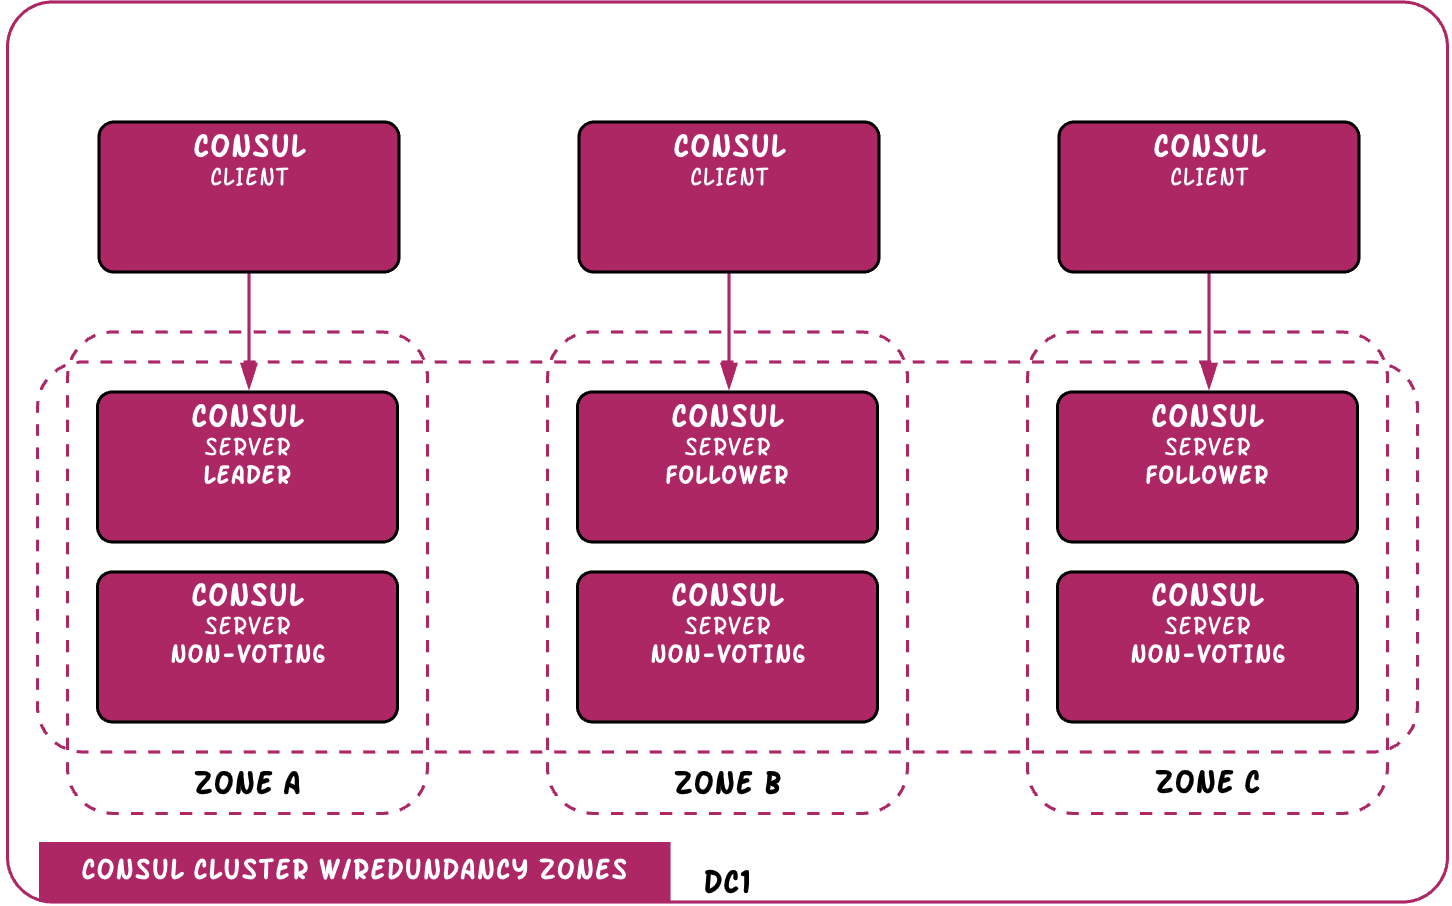

> **NOTE**: This is an Enterprise only feature.

You will configure fault resiliency for Consul using redundancy zones.

Redunancy zones is a Consul autopilot feature that makes it possible to run:
* **one voter** and any number of non-voters in each defined zone.

You will set up one voter and one non-voter in three regions.
* If one zone is completely lost, both the the voter and non-voters will be lost.
  * However, the the cluster will remain available.
* If only the voter is lost in a zone, autopilot will promote the non-voter to voter automatically.
  * Puts the hot standby server into service quickly.

You will implement isolated failure domains such as AWS Availability Zones to obtain redundancy within an AZ with less overhead sustained by a larger quorum.

### Prerequisites

You will need:
* A Consul Enterprise cluster with three servers. See `Consul Setup`.
* Three extre nodes to be used as non-voters.

### Create Consul config for Redundancy Zone.

This is for the three servers currently running. 

In [ ]:
for i in {0..2}; do
docker exec -i consul-server-${i} sh <<EOM
cat > /consul/config/rz.hcl <<EOF
node_meta {
  zone = "zone${i}"
}
EOF
cat /consul/config/rz.hcl
consul reload
EOM
done

* `node_meta` allows us to add a tag `zone` to a server
* `consul reload` triggers a reload of the configuration files. 

Verify the configuration is in place using the `/agent/self` API endpoint.

In [ ]:
for i in {0..2}; do
docker exec consul-server-${i} \
curl -s localhost:8500/v1/agent/self | jq ". | .Config, .Meta"
done

We check all three servers. We use `docker exec` since only one server container is exposing ports.

Expected Output
```json
...
{
  "consul-network-segment": "",
  "zone": "zone0"
}
...
```

### Update Consul autopilot configuration

Update Consul autopilot configuration so it knows which `node_meta` tag is used for `-redundancy-zone-tag`.

In [ ]:
#// Confirm nothing is currently set.
consul operator autopilot get-config | grep Redundancy

```
RedundancyZoneTag = ""
```

In [ ]:
consul operator autopilot set-config -redundancy-zone-tag=zone

### Verify autopilot updates

In [ ]:
consul operator autopilot get-config

Sample Output
```shell
CleanupDeadServers = true
LastContactThreshold = 200ms
MaxTrailingLogs = 250
MinQuorum = 0
ServerStabilizationTime = 10s
RedundancyZoneTag = "zone"   <==---
DisableUpgradeMigration = false
UpgradeVersionTag = ""
```

### Create Consul config - Redundancy Zone for new nodes

In [ ]:
for i in {0..2}; do
cat > consul/config/rz-${i}.hcl <<-EOF
node_meta {
  zone = "zone${i}"
}
autopilot {
  redundancy_zone_tag = "zone"
}
EOF
done

Server 3, 4, and 5 are used for various scenarios. In this scenario, we can reuse the configs from the first cluster.

In [ ]:
cp consul/config/server.hcl consul/config/server_dc2.hcl
cp consul/config/server.hcl consul/config/server_dc3.hcl
cp consul/config/server.hcl consul/config/server_dc4.hcl

Click here if you want to view the config files.
* [server.hcl](./consul/config/server.hcl)
* [server_dc2.hcl](./consul/config/server_dc2.hcl)

Modify [docker-compose-hashi.yml](docker-compose-hashi.yml). For `consul-server-3`, uncomment the image parameter for `1.9` and comment the one for `latest`. Servers 4 and 5 will inherit the settings.

```yaml
    image: hashicorp/consul-enterprise:1.9-ent
    # image: hashicorp/consul-enterprise:latest
```

### Bring up new Consul nodes

Start `consul-server-3` `consul-server-4` `consul-server-5`. Make `CONSUL_DC` `CONSUL_DC_2` and `CONSUL_DC_3` is set.

In [ ]:
docker-compose up --force-recreate -d \
  consul-server-3 consul-server-4 consul-server-5

Verify Consul with `operator` subcommand.

In [ ]:
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers

Sample Output
```
#==> List Members
Node             Address         Status  Type    Build       Protocol  DC    Segment
consul-server-0  10.5.0.2:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-1  10.5.0.3:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-2  10.5.0.4:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-3  10.5.0.7:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-4  10.5.0.6:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-5  10.5.0.5:8301   alive   server  1.9.11+ent  2         west  <all>
App1             10.5.0.12:8301  alive   client  1.9.11+ent  2         west  <default>

#==> List Raft Peers
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  follower  true   3
consul-server-1  d7e82aa0-2fa0-9308-5970-44e839786d2b  10.5.0.3:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  false  3
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
```

* **NOTE:** All the new servers, once started, are added to the datacenter as non-voters (`Voter` = `false`). You can reference the Voter column in the output to verify it.

### Test fault tolerance

Stop one of the voters. We use `consul-server-1` from `zone1`.

In [ ]:
docker stop consul-server-1

Verify that the correspondent non-voter in its redundancy zone (`consul-server-4`) gets promoted as a voter as soon as the stopped server (`consul-server-1`) gets declared unhealthy.

In [ ]:
consul operator raft list-peers

```shell
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  true   3   <==---
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
```

* `consul-server-4` from `zone1` is now a voter

<br>Once `server-server-4` gets promoted as a voter you can start Consul on `consul-server-1` again and verify the one voter per redundancy zone rule is still respected.

In [ ]:
docker start consul-server-1

In [ ]:
consul operator raft list-peers

```shell
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  true   3
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
consul-server-1  d7e82aa0-2fa0-9308-5970-44e839786d2b  10.5.0.3:8300  follower  false  3   <==---
```

**NOTE:** `consul-server-1` is up as a `follower`, but is no longer a `voter`.

If you no longer need these nodes you can stop them.

Stop `consul-server-3` `consul-server-4` `consul-server-5`.

In [ ]:
for i in {3..5}; do
echo "#==> Stopping consul-server-${i}"
docker-compose stop consul-server-${i}
sleep 2
done

In [ ]:
consul operator raft list-peers

### Troubleshooting

```
Failed to join 10.5.0.2: No installed keys could decrypt the message
```

* https://learn.hashicorp.com/tutorials/consul/gossip-encryption-rotate

List current keys

Create new keys

In [ ]:
export CONSUL_HTTP_ADDR="http://localhost:8500"
export NEW_KEY=`consul keygen`
echo $NEW_KEY

for i in {0..5}; do
docker exec -i consul-server-${i} sh <<EOM
# Install the key
consul keyring -install ${NEW_KEY}

# Set as primary
consul keyring -use ${NEW_KEY}
EOM
done

Delete old keys

In [ ]:
for i in {0..5}; do
docker exec -i \
  -e CONSUL_HTTP_ADDR=$CONSUL_HTTP_ADDR \
  -e NEW_KEY=$NEW_KEY \
  consul-server-${i} \
  sh -s <<"EOM"
echo "#==> Retrieve all keys used by Consul"
echo "Host: $(hostname)"
KEYS=$(curl -s http://localhost:8500/v1/operator/keyring)
#echo Keys: $KEYS #DEBUGGING 
ALL_KEYS=$(echo ${KEYS} | jq -r '.[].Keys| to_entries[].key' | sort | uniq)

echo "#==> Delete all older keys used by Consul"
for i in `echo ${ALL_KEYS}`; do
  # echo $i #DEBUGGING
  if [ $i != ${NEW_KEY} ] ; then
    echo consul keyring -remove $i
    consul keyring -remove $i
  fi
done
EOM
done

`last_log_index` and `commit_index`


## Consul Federation Using WAN Gossip

* We configure two new clusters: `dc2` and `dc3` unless you renamed them in the prerequisites.
* We will use containers `consul-server-3` and `consul-server-4`for this.


### Create Server Configuration - DC2 and DC3

<img alt="consul_wan_fed_diagram" src=attachment:165e3aff-75e0-484e-80bc-0e7e4e686fd5.png width=640>
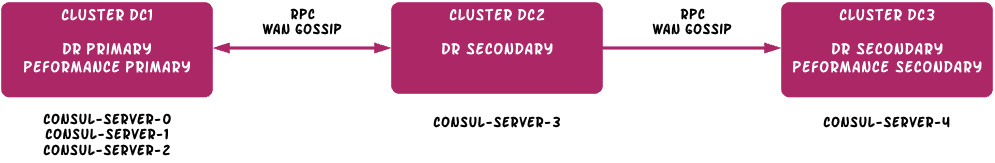

Create Core Consul config - Server

In [ ]:
#// debugging - in case variable from earlier was lost
# export CONSUL_KEY="Y+rrmAn0c9R7MLIf/eRNOjvglJA+z9dY/uqyqitaB0E="

In [ ]:
tee /tmp/consul_server.hcl.j2 <<-EOF
#// Consul Config created by automation
datacenter  = "{{cluster_name}}" # in CLI
# node_name   = "ConsulServer{{node_number}}" # in CLI
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"
log_level   = "DEBUG"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/{{cluster_name}}-server-consul-0.pem"
key_file    = "/consul/cert/{{cluster_name}}-server-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

# server           =  true # in CLI
bootstrap_expect = 1
#retry_join  = [ "consul-server-3", "consul-server-4", "consul-server-5" ]
ui_config { enabled = true } 

#// 5 is default multiplier
performance {
  raft_multiplier = 2 #// fast but not too fast
}

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

In [ ]:
ansible localhost -m template -a "src=/tmp/consul_server.hcl.j2 dest=consul/config/server_dc2.hcl" \
    --extra-vars "node_number=3 cluster_name=${CONSUL_DC_2}"
ansible localhost -m template -a "src=/tmp/consul_server.hcl.j2 dest=consul/config/server_dc3.hcl" \
    --extra-vars "node_number=4 cluster_name=${CONSUL_DC_3}"
printf "\n#==> Verify Configs\n"
cat consul/config/server_dc2.hcl
printf "\n#==> Verify Configs\n"
cat consul/config/server_dc3.hcl

```shell
    #//
    #- NO LONGER IN USE - HERE ONLY FOR COMPARISON
    #//

    tee consul/config/server_dc2.hcl <<-EOF
    datacenter  = "${CONSUL_DC_2}" # in CLI
    # node_name   = "ConsulServer${i}" # in CLI
    bind_addr   = "0.0.0.0" #default
    client_addr = "0.0.0.0" #default 127.0.0.1
    data_dir    = "/consul/data"
    log_level   = "DEBUG"

    encrypt     = "${CONSUL_KEY}"
    ca_file     = "/consul/cert/consul-agent-ca.pem"
    cert_file   = "/consul/cert/${CONSUL_DC_2}-server-consul-0.pem"
    key_file    = "/consul/cert/${CONSUL_DC_2}-server-consul-0-key.pem"
    verify_incoming = true
    verify_outgoing = true
    verify_server_hostname = true

    # server           =  true # in CLI
    bootstrap_expect = 1
    retry_join  = [ "consul-server-3", "consul-server-4", "consul-server-5" ]
    ui_config { enabled = true } 

    #// 5 is default multiplier
    performance {
      raft_multiplier = 2 #// fast but not too fast
    }

    discovery_max_stale = "5s"

    telemetry {
        prometheus_retention_time = "8h",
        disable_hostname = true
    }

    connect {
        enabled = true
    }

    enable_local_script_checks = true
    EOF
```

### Consul docker-compose up

We will now bring up the three Consul servers in a second Consul Cluster. You can use `--force-recreate` to have Docker recreate the containers.

In [ ]:
echo $CONSUL_DC $CONSUL_DC_2 $CONSUL_DC_3
docker-compose \
  up --force-recreate -d \
  consul-server-3 consul-server-4 #consul-server-5

### Verify Consul

Quick check to make sure your Consul environment is running correctly.

#### Verify dc2

We use `docker exec` to run these commands from the containers.

In [ ]:
docker exec -i consul-server-3 sh <<EOM
echo export CONSUL_HTTP_TOKEN=$CONSUL_HTTP_TOKEN
printf "\n #==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services
EOM

Confirm that the DC is your `DC2` and not your DC1.

#### Verify dc3

In [ ]:
docker exec -i consul-server-4 sh <<EOM
echo export CONSUL_HTTP_TOKEN=$CONSUL_HTTP_TOKEN
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services
EOM

Confirm that the DC is your `DC3` and not your DC1.

You should see something like the following
* There should be one server.
```
Node             Address        Status  Type    Build       Protocol  DC     Segment
consul-server-4  10.5.1.3:8301  alive   server  1.9.11+ent  2         zone3  <all>
```

* There should be only a `leader` and no `follower`'s.

```
#==> List Raft Peers
Node             ID                                    Address        State   Voter  RaftProtocol
consul-server-4  485a3739-c4fa-8265-8441-751e9f00d4dd  10.5.1.3:8300  leader  true   3
```

```
#==> List services from Consul catalog
consul
```

Look for any strangeness in the logs.

In [ ]:
for i in {3..4}; do
docker logs consul-server-${i} | (head; tail -n 5)
done

### Confirm the Datacenters are Joined and Replicating Tokens

NOTE: If ACL Tokens have not been enabled, then there will be no tokens to replicate:

First, confirm that the clusters are not aware of each other.

In [ ]:
for i in 0 3 4; do
printf "\n#==> List Consul Members\n"
docker exec consul-server-${i} consul members -wan
done

<br>Sample Output

```shell
#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-0.zone1  10.5.0.2:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-1.zone1  10.5.0.3:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-2.zone1  10.5.0.4:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-3.zone2  10.5.1.2:8302  failed  server  1.9.11+ent  2         zone2  <all>
consul-server-4.zone3  10.5.1.3:8302  failed  server  1.9.11+ent  2         zone3  <all>

#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-3.zone2  10.5.1.2:8302  alive   server  1.9.11+ent  2         zone2  <all>

#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-4.zone3  10.5.1.3:8302  alive   server  1.9.11+ent  2         zone3  <all>
```

Join the Datacenters - consul-server-0 will reach out to consul-server-3 and consul-server-4.

In [ ]:
consul join -wan consul-server-3 consul-server-4

#### Verify Consul Federation

Once the join is complete, the `members` command can be used to verify that all server nodes gossiping over WAN.

In [ ]:
for i in 0 3 4; do
printf "\n#==> List Consul Members\n"
docker exec consul-server-${i} consul members -wan
done

**NOTE**: Each cluster show now see members of the other clusters.

Sample Output
```shell
#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-0.zone1  10.5.0.2:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-1.zone1  10.5.0.3:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-2.zone1  10.5.0.4:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-3.zone2  10.5.1.2:8302  alive   server  1.9.11+ent  2         zone2  <all>
consul-server-4.zone3  10.5.1.3:8302  alive   server  1.9.11+ent  2         zone3  <all>
```

Find out which Datacenters Consul is aware of.

In [ ]:
curl http://localhost:8500/v1/catalog/datacenters

Check that ACL replication is configured properly in the secondary datacenter. **NOTE**: This should not work, yet, if you have not enabled ACL's.

In [ ]:
docker exec -i consul-server-0 sh <<EOF
echo "#==> From dc1"
apk add curl
curl -s http://localhost:8500/v1/acl/replication?pretty
printf "\n\n"; echo "#==> From dc2"
curl -s http://consul-server-3:8500/v1/acl/replication?pretty
printf "\n\n"; echo "#==> From dc3"
curl -s http://consul-server-4:8500/v1/acl/replication?pretty
EOF

Query the nodes in each datacenter

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do
printf "\n#==> Show nodes in ${cluster}\n"
docker exec consul-server-0 \
  curl -s http://localhost:8500/v1/catalog/nodes?dc=${cluster} | jq -c .[]
done

Query for service in both datacenters - `consul.service.west.consul` and `consul.service.east.consul` 

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do
printf "\n#==> DNS query for consul in ${cluster}\n"
dig @127.0.0.1 -p 8600 consul.service.${cluster}.consul | grep -C3 "ANSWER SECTION"
done

<br>**NOTES:**

* All server nodes must be able to talk to each other; Else gossip and RPC forwarding will not work
* Data is not replicated between Consul Clusters
  * Request made for resource in another datacenter is forwarded to remote Consul Servers
  

### Next Steps for Consul Federation

* [Prepared Queries](../Consul/consul_automate_geo_failover.ipynb)

## Consul Auto Upgrade

Modify `docker-compose-hashi.yml`. For consul-server-3, 4, and 5, comment the image parameter for `1.9` and uncomment the one for `latest`.

```yaml
    # image: hashicorp/consul-enterprise:1.9-ent
    image: hashicorp/consul-enterprise:latest
```

Start consul-server-3 consul-server-4 consul-server-5

In [ ]:
docker-compose -f docker-compose-hashi.yml up --force-recreate -d \
  consul-server-3 consul-server-4 consul-server-5

Verify Consul

In [ ]:
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers

## Consul ACL Configuration

Create Consul config for misc features eg `acl`, `performance multiplier`, etc

In [ ]:
cat > consul/config/acl.hcl << EOF
# acl = {
#   enabled = true
#   default_policy = "deny"
#   down_policy    = "extend-cache"
#   enable_token_persistence = true
#   # tokens = {
#   #   master = "49792521-8362-f878-5a32-7405f1783838"
#   # }
# }
EOF

In [ ]:
for i in {0..2}; do
docker-compose restart consul-server-${i}
sleep 3
done

In [ ]:
consul members
consul operator raft list-peers

If ACLs are enabled correctly, the leader's logs will contain the following warning and info messages.

In [ ]:
docker-compose logs --tail=100 | grep -i acl | grep INFO

### Create the bootstrap token

In [ ]:
consul acl bootstrap

**VERIFY** - The logs should contain the following log message.

In [ ]:
docker-compose logs --tail=100 | grep "ACL bootstrap"
docker-compose logs --tail=100 | grep "/v1/acl/bootstrap"

In [ ]:
echo "#==> Without Token - will see no output"
consul members
echo "#==> With Token"
CONSUL_HTTP_TOKEN=1eb8a07d-3b5a-9069-2673-e031a48851a7 consul members

### Configure Environment Variables

In [ ]:
export CONSUL_HTTP_TOKEN=1eb8a07d-3b5a-9069-2673-e031a48851a7
# export CONSUL_CACERT=/etc/training/consul/consul-agent-ca.pem
# export CONSUL_CLIENT_CERT=/etc/training/consul/<dc-name>-<server/client>-consul-<cert-number>.pem
# export CONSUL_CLIENT_KEY=/etc/training/consul/<dc-name>-<server/client>-consul-<cert-number>-key.pem

### Apply the Bootstrap Token to the Agents

In [ ]:
for i in {0..2}; do
docker exec -i consul-server-${i} sh <<EOF
hostname
consul acl set-agent-token agent $CONSUL_HTTP_TOKEN
EOF
done

ACL token "agent" set successfully

### Validate Consul Configuration

In [ ]:
consul validate consul/config/ || true

If you see this: `Config validation failed: 'bootstrap_expect > 0' requires 'server = true'`, you can ignore. We specify this from the command line.

In [ ]:
consul members
consul operator raft list-peers

Check on the UI

1. Go to http://192.168.17.101:8500
1. Then go to ACL and enter the token.
1. Go to `Nodes` tab and verify you can see the nodes.


## Vault DR and PR

## Debug - Network

In [ ]:
docker exec -i consul-server-0 sh <<"EOM"
hostname
for i in consul-server-1 consul-server-2 consul-agent-1; do
ping -qc 1 ${i}
done
EOM

### docker-compose restart

In [ ]:
docker-compose -f docker-compose-hashi.yml restart

### docker-compose down

In [ ]:
docker-compose -f docker-compose-hashi.yml down

In [ ]:
docker-compose stop grafana prometheus

### Restart Vault Cluster

In [ ]:
docker-compose -f docker-compose-hashi.yml restart vault_s1 vault_s2 vault_s3

## Vault DB

In [ ]:
# This script configures a Postgres Dynamic Database credential database for benchmarking
vault secrets enable database

vault write database/config/postgres \
  plugin_name=postgresql-database-plugin \
  allowed_roles="*" \
  connection_url="postgresql://{{username}}:{{password}}@db:5432/products?sslmode=disable" \
  username="postgres" \
  password="password"

vault write database/roles/benchmarking \
    db_name=postgres \
    creation_statements="CREATE ROLE \"{{name}}\" WITH LOGIN PASSWORD '{{password}}' VALID UNTIL '{{expiration}}'; \
        GRANT SELECT ON ALL TABLES IN SCHEMA public TO \"{{name}}\";" \
    default_ttl="24h" \
    max_ttl="48h"

vault read database/creds/benchmarking

Admin token (optional): You may prefer using an admin token instead of root (for example if you’re using an existing cluster). If so, create an admin token using the vault-admin.hcl policy file shown below. This admin policy is authored based on the Vault Policies guide.

In [ ]:
# Assuming that VAULT_TOKEN is set with root or higher Admin token
vault policy write learn-admin admin-policy.hcl
vault token create -policy=learn-adminexport
VAULT_TOKEN=<token-from-above command>
vault token lookup

In [ ]:
consul members
consul operator raft list-peers
consul operator autopilot get-config
vault operator raft list-peers

## Onboarding App

In [ ]:
vault secrets list
vault read database/config/postgres

### Vault Onboarding docker-compose up

We will now bring up the three Consul servers and one client. You can use `--force-recreate` to have Docker recreate the containers.

In [ ]:
# export CONSUL_DC=west CONSUL_DC_2=east
docker-compose \
  up --force-recreate -d \
  db web vault-agent haproxy

In [ ]:
git clone https://github.com/hashicorp/vault-guides.git tmp/vault-guides

In [ ]:
cp tmp/vault-guides/operations/onboarding/terraform/*.* terraform/

In [ ]:
cp -r tmp/vault-guides/operations/onboarding/docker-compose/vault-agent .

### Vault administration with Terraform

Modifications: 

* I modified the `auth.tf`. Changed the local file destination since `vault-agent` folder is not under `docker-compose` folder.

In [ ]:
TF_CLI_ARGS="-input=false"

In [ ]:
terraform -chdir=terraform init

In [ ]:
terraform -chdir=terraform plan

In [ ]:
terraform -chdir=terraform apply -auto-approve

In [ ]:
docker restart vault-agent

Access http://localhost:8080 on your browser, and you should be able to see the nginx application display a dynamic PostgreSQL database credential provided by Vault as shown below. Also try accessing http://localhost:8080/kv.html to see example static secret values.



<img src="https://www.datocms-assets.com/2885/1624893789-vtf-onboarding-2.png?fit=max&fm=webp&q=80&w=2500" width=640 />

The Terraform configurations for this demo are described in more detail below along with the corresponding source file names:

* "**Application entity**" — `entity.tf`:
  * Pre-creating the application entity is optional but encouraged.
  * It allows easier auditing and more flexibility in attaching ACL policies.
  1. Please log in to the Vault UI on http://localhost:8200 with the root token
  1. Then click `Access` > `Entities`. You should see two created entities: `nginx` and `app100`.
  1. Clicking into these entities will display
      * an alias for the AppRole authentication method 
      * and the mapped entity ACL policies.
* "Authentication method" — `auth.tf`:
  * This demo uses the AppRole auth method, which is a type of “trusted orchestrator” secure introduction pattern.
  * An authentication method alias links the entity to the AppRole role.
* "ACL policy" — `entity.tf`: We recommend using templated policies to reduce the overhead of policy management.
  * This demo uses two templated policies:
    * `kv_rw_policy` for accessing key-value secrets
    * `postgres_creds_policy` for accessing dynamic Postgres credentials.

These elements are represented as a Terraform graph diagram snippet, shown below:

Terraform graph snippet for authentication, entity, and ACL policy.

<img src="https://www.datocms-assets.com/2885/1624893793-vtf-onboarding-3.png?fit=max&fm=webp&q=80&w=2500" width=640 />

### Application Integration with Vault

Now that the Vault configurations are built, we need the application to log in to Vault using AppRole credentials and fetch a secret. The demo uses Vault Agent to achieve this (see App Integration for more patterns).
Vault Agent workflow.

Vault Agent workflow.

<img src="https://www.datocms-assets.com/2885/1624893810-vtf-onboarding-5.png?fit=max&fm=webp&q=80&w=2500" width=640 />

The file `nginx-vault-agent.hcl` specifies how to authenticate the `nginx` container using AppRole. It also links two template files, `kv.tpl` and `postgres.tpl`, that tell Vault Agent how to render secrets from a KV and Database Secrets Engine respectively.

### Register a service

In [ ]:
docker exec -i consul-server-1 sh <<EOM
cat > /consul/config/webapp.hcl <<EOF
service {
  name = "webapp",
  port = 80,
  check {
    http = "http://demo-webapp",
    interval = "5s"
  }
}
EOM

In [ ]:
docker exec consul-server-1 consul reload

### Onboarding the Next Application

To onboard another application, simply add its name to the default value of the entities variable in `variables.tf` as shown below for `app200`.

# Snippet from variables.tf after adding app200

In [ ]:
cat > terraform/terraform.tfvars <<EOF
entities = [
    "nginx",
    "app100",
    "app200"
]
EOF

Then run `terraform apply` to create the additional Vault configurations for this application:

NOTE: Ensure that `VAULT_TOKEN` was set from before

In [ ]:
terraform -chdir=terraform validate && \
terraform -chdir=terraform apply -auto-approve

Verify from the Vault UI that there is a new entity called `app200` with an alias to the AppRole auth method:

Vault screenshot showing a new app200 entity being added.

Vault screenshot showing a new app200 entity being added.

A new Role ID and Secret ID have also been created, which you can find by running the terraform output command. We can use this to test authentication and secret access as shown below. Note that the Role ID, Secret ID, and Vault token will be unique in your case.

In [ ]:
terraform -chdir=terraform output -json > /tmp/approle_200.txt

In [ ]:
ROLE_ID=$(jq -r .role_ids.value.app200 /tmp/approle_200.txt)
SECRET_ID=$(jq -r .secret_ids.value.app200 /tmp/approle_200.txt)

In [ ]:
Login using AppRole

In [ ]:
vault write -format=json auth/approle/login \
  role_id=${ROLE_ID} \
  secret_id=${SECRET_ID} | tee /tmp/approle_200.token

In [ ]:
VAULT_TOKEN_APP200=$(jq -r .auth.client_token /tmp/approle_200.token) && echo $VAULT_TOKEN_APP200

Read KV secret

In [ ]:
VAULT_TOKEN=${VAULT_TOKEN_APP200} vault kv get kv/app200/static

Sample Output
```
====== Metadata ======
Key              Value
---              -----
created_time     2021-11-16T20:49:58.138197524Z
deletion_time    n/a
destroyed        false
version          1

====== Data ======
Key         Value
---         -----
app         app200
password    cheese
username    app200
```

To de-board an application, simply remove the entity from the same variable and re-rerun `terraform apply`.

Gabe's Envoy Notes

```
sudo apt install -y apt-transport-https gnupg2 curl lsb-release
curl -sL 'https://deb.dl.getenvoy.io/public/gpg.8115BA8E629CC074.key' | sudo gpg --dearmor -o /usr/share/keyrings/getenvoy-keyring.gpg
echo "deb [arch=amd64 signed-by=/usr/share/keyrings/getenvoy-keyring.gpg] https://deb.dl.getenvoy.io/public/deb/ubuntu $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/getenvoy.list
sudo apt update
sudo apt install -y getenvoy-envoy

envoy --version
```

# Grafana Dashboards Vault

https://docs.datadoghq.com/integrations/vault/?tab=host


GC pause time (ns)
{
"viz": "timeseries",
"query": "avg:service.vault_runtime_gc_pause_ns.quantile{$vault_cluster,quantile:0.9} by {host}",
"data_source": "metrics",
"type": "line",
            "style": {
                "palette": "dog_classic",
                "type": "solid",
                "width": "normal"
            }
        }
    ],
    "yaxis": {
        "include_zero": true,
        "max": "auto",
        "scale": "linear",
        "min": "auto",
        "label": ""
    },
    "markers": []
}

In [ ]:
cat > /tmp/generate_traffic_vault.sh <<"EOF"
#!/bin/bash
echo $VAULT_TOKEN
vault secrets list
vault secrets enable kv || true
vault secrets enable -path=kv-peter kv || true
for i in {1..1}; do
vault secrets enable -path=kv-app-${i} kv > /dev/null || true
done

printf "\n#==> write and read secrets\n"
for i in {1..10}; do
vault kv put kv/game/account-${i} username=foo-${i} password=bar
vault kv get kv/game/account-${i} > /dev/null
vault kv put kv-peter/data/game/account-${i} username=foo-${i} password=bar
vault kv get kv-peter/data/game/account-${i} > /dev/null
done

printf "\n#==> write and read secrets\n"
for i in {1..10}; do
vault kv put kv-app-${i}/game/account-${i} username=foo-${i} password=bar
vault kv get kv-app-${i}/game/account-${i} > /dev/null
done

printf "\n#==> create tokens\n"
for i in {1..10}; do
vault token create \
  -field=token \
  -policy prometheus-metrics \
  -ttl=1h
done

vault auth enable userpass || true
vault write auth/userpass/users/mitchellh password=foo policies=admin
for i in {1..10}; do
printf "\n#==> create userpass user\n"
vault write auth/userpass/users/user-${i} password=foo policies=operators \
    token_ttl=1h policies=operators
printf "\n#==> login with userpass user\n"
vault login -method=userpass username=user-${i} password=foo
done
EOF

chmod +x /tmp/generate_traffic_vault.sh

Run script and display for debugging.

In [ ]:
/tmp/generate_traffic_vault.sh

Run script in background.

In [ ]:
/tmp/generate_traffic_vault.sh > /tmp/generate_traffic_vault.out 2>&1 &

In [ ]:
# for i in {1..10}; do
# vault write auth/userpass/users/user-${i} password=foo policies=admins
# done

for i in {1..10}; do
# vault kv list kv-app-${i}/game > /dev/null
vault login -method=userpass username=user-${i} password=foo 2>&1 > /dev/null
done

# Ansible Dockerfile

In [ ]:
docker run --rm -h ansible --name ansible \
    -v ${PWD}:/ansible/playbooks:ro \
    -v ~/.ssh:/root/.ssh \
    peterphan/ansible:latest \
    ansible --version

# Ansible

In [ ]:
alias ansible="docker run -ti --rm -v ~/.ssh:/root/.ssh -v ~/.aws:/root/.aws -v $(pwd):/apps -w /apps alpine/ansible ansible"
alias ansible-playbook=" docker run -ti --rm -v ~/.ssh:/root/.ssh -v ~/.aws:/root/.aws -v $(pwd):/apps -w /apps alpine/ansible ansible-playbook"

ansible
ansible-playbook -i inventory < follow command>


# Additional Consul Steps - TBC

Setup Consul environment variables - Notice that since TLS encryption is enabled, you will now need to use the server certificates to complete all other tasks.

In [ ]:
export CONSUL_CACERT=/etc/consul.d/consul-agent-ca.pem
export CONSUL_CLIENT_CERT=/etc/consul.d/<dc-name>-<server/ client>-consul-<cert-number>.pem
export CONSUL_CLIENT_KEY=/etc/consul.d/<dc-name>-<server/   client>-consul-<cert-number>-key.pem